# Imports etc.

In [1]:
import ipdb
import numpy as np
import os
import pandas as pd
import plotnine as gg
import scipy
gg.theme_set(gg.theme_bw)

In [4]:
fitted_param_dir = 'C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice/'
plot_dir = 'C:/Users/maria/MEGAsync/SLCN/models/plots'
mouse_data_dir = 'C:/Users/maria/MEGAsync/SLCN/PSMouseData'

In [13]:
save_or_load_true_mouse_dat = 'save'  # 'load'

# Load mouse data

In [8]:
n_trials = 725

In [9]:
def replace_nans(data):

    data[np.isnan(data)] = np.random.binomial(1, 0.5, np.sum(np.isnan(data)))
    return data

# Example use
replace_nans(np.full(10, np.nan))

array([1., 1., 0., 1., 0., 1., 0., 0., 0., 0.])

In [14]:
if save_or_load_true_mouse_dat == 'save':
    # Load data
    rewards_j = pd.read_csv(os.path.join(mouse_data_dir, 'Juvi_Reward.csv')).T.values[:n_trials]
    rewards_a = pd.read_csv(os.path.join(mouse_data_dir, 'Adult_Reward.csv')).T.values[:n_trials]
    actions_j = pd.read_csv(os.path.join(mouse_data_dir, 'Juvi_Choice.csv')).T.values[:n_trials]
    actions_a = pd.read_csv(os.path.join(mouse_data_dir, 'Adult_Choice.csv')).T.values[:n_trials]
    correct_actions_j = pd.read_csv(os.path.join(mouse_data_dir, 'Juvi_TaskData.csv')).T.values[:n_trials]
    correct_actions_a = pd.read_csv(os.path.join(mouse_data_dir, 'Adult_TaskData.csv')).T.values[:n_trials]
    fullID_j = pd.read_csv(os.path.join(mouse_data_dir, 'Juvi_AnimalID.csv')).T.values.flatten()
    fullID_a = pd.read_csv(os.path.join(mouse_data_dir, 'Adult_AnimalID.csv')).T.values.flatten()

    # Clean data
    n_trials_per_animal = np.sum(np.invert(np.isnan(rewards_j)), axis=0)
    n_trials = np.round(np.percentile(n_trials_per_animal, 0.8)).astype('int')
    rewards_j = replace_nans(rewards_j).astype('int')
    actions_j = replace_nans(actions_j).astype('int')
    rewards_a = replace_nans(rewards_a).astype('int')
    actions_a = replace_nans(actions_a).astype('int')
    correct_actions_j = replace_nans(correct_actions_j).astype('int')
    correct_actions_a = replace_nans(correct_actions_a).astype('int')

    # Combine juvenile and adult data
    fullIDs = np.concatenate([fullID_j, fullID_a])
    animals = [int(str(fullID)[:-5]) for fullID in fullIDs]
    ages = [int(str(fullID)[-5:-2]) for fullID in fullIDs]
    rewards = np.hstack([rewards_j, rewards_a])  # (n_trials, n_cols)
    actions = np.hstack([actions_j, actions_a])
    correct_actions = np.hstack([correct_actions_j, correct_actions_a])
    corrects = (actions == correct_actions).astype('int')
    rewards[corrects == 0] = 0  # to fix errors of replace_nans
    assert np.shape(rewards) == np.shape(actions)

## Format mouse data

In [20]:
true_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_mouse_data.csv'))


In [29]:
np.median(true_dat.groupby(['animal', 'age', 'block']).aggregate('count').reset_index()['action'])

22.0

In [44]:
block_length = sum(subj_dat.block == block)
# subj_dat.loc[subj_dat.block == block, 'trials2swith'] = 
len(np.append(np.arange(block_length-3), np.arange(-3, 0)))

27

In [48]:
len(np.append([np.nan], subj_dat['reward'][:-1]))

725

In [53]:
true_dat = pd.DataFrame()
for i, fullID in enumerate(fullIDs[:10]):

    # Basic info
    subj_dat = pd.DataFrame({
        'animal': int(str(fullID)[:-5]),
        'age': int(str(fullID)[-5:-2]),
        'action': actions[:, i],
        'reward': rewards[:, i],
        'correct': corrects[:, i],
        'correct_action': correct_actions[:, i],
        'trial': range(len(actions)),
        'block': np.append([0], np.cumsum(np.abs(np.diff(correct_actions[:, i])))),
        'gender': int(str(fullID)[-2:-1]),
        'agegroup': int(str(fullID)[-1:]),
        'fullID': [fullID] * len(actions),
    })
    
    # Advanced info
    subj_dat['rew_1ago'] = np.append([np.nan], subj_dat['reward'][:-1])
    subj_dat['rew_2ago'] = np.append([np.nan], subj_dat['rew_1ago'][:-1])

    # Block info
    for block in np.unique(subj_dat.block):
        block_length = sum(subj_dat.block == block)
        subj_dat.loc[subj_dat.block == block, 'block_trial'] = range(block_length)
        subj_dat.loc[subj_dat.block == block, 'trials2swith'] = np.append(np.arange(block_length-3), np.arange(-3, 0))

    true_dat = true_dat.append(subj_dat)

for animal in np.unique(true_dat.animal):
    ani_age = true_dat.loc[true_dat.animal == animal, 'age']
    true_dat.loc[true_dat.animal == animal, 'session'] = ani_age - np.min(ani_age)
true_dat['gender'] = true_dat['gender'].astype('category')

In [54]:
true_dat

,animal,age,action,reward,correct,correct_action,trial,block,gender,agegroup,fullID,rew_1ago,rew_2ago,block_trial,trials2swith,session
0,14,40,0,0,0,1,0,0,1,2,1404012,NaN,NaN,0.0,0.0,0
1,14,40,0,0,0,1,1,0,1,2,1404012,0.0,NaN,1.0,1.0,0
2,14,40,1,1,1,1,2,0,1,2,1404012,0.0,0.0,2.0,2.0,0
3,14,40,1,1,1,1,3,0,1,2,1404012,1.0,0.0,3.0,3.0,0
4,14,40,1,1,1,1,4,0,1,2,1404012,1.0,1.0,4.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,14,49,1,1,1,1,720,28,1,2,1404912,1.0,1.0,6.0,6.0,9
721,14,49,1,0,1,1,721,28,1,2,1404912,1.0,1.0,7.0,7.0,9
722,14,49,1,1,1,1,722,28,1,2,1404912,0.0,1.0,8.0,-3.0,9
723,14,49,1,1,1,1,723,28,1,2,1404912,1.0,0.0,9.0,-2.0,9


In [64]:
subj_dat.loc[(subj_dat.block == block),]

,animal,age,action,reward,correct,correct_action,trial,block,gender,agegroup,fullID,rew_1ago,rew_2ago,block_trial,trials2swith
724,16,41,0,0,0,1,724,30,1,2,1604112,1.0,1.0,0.0,NaN


In [69]:
if save_or_load_true_mouse_dat == 'save':
    
    true_dat = pd.DataFrame()
    for i, fullID in enumerate(fullIDs):
        
        # Basic info
        subj_dat = pd.DataFrame({
            'animal': int(str(fullID)[:-5]),
            'age': int(str(fullID)[-5:-2]),
            'action': actions[:, i],
            'reward': rewards[:, i],
            'correct': corrects[:, i],
            'correct_action': correct_actions[:, i],
            'trial': range(len(actions)),
            'block': np.append([0], np.cumsum(np.abs(np.diff(correct_actions[:, i])))),
            'gender': int(str(fullID)[-2:-1]),
            'agegroup': int(str(fullID)[-1:]),
            'fullID': [fullID] * len(actions),
        })

        # Advanced info
        subj_dat['rew_1ago'] = np.append([np.nan], subj_dat['reward'][:-1])
        subj_dat['rew_2ago'] = np.append([np.nan], subj_dat['rew_1ago'][:-1])

        # Block info
        for block in np.unique(subj_dat.block):
            block_length = sum(subj_dat.block == block)
            
            if block_length > 5:
                block_trial = range(block_length)
                trials2switch = np.append(np.arange(block_length-3), np.arange(-3, 0))
            else:
                block_trial = [np.nan] * block_length
                trials2switch = [np.nan] * block_length
                
            subj_dat.loc[subj_dat.block == block, 'block_length'] = block_length
            subj_dat.loc[subj_dat.block == block, 'block_trial'] = block_trial
            subj_dat.loc[subj_dat.block == block, 'trials2switch'] = trials2switch

        true_dat = true_dat.append(subj_dat)

    # Session and gender
    for animal in np.unique(true_dat.animal):
        ani_age = true_dat.loc[true_dat.animal == animal, 'age']
        true_dat.loc[true_dat.animal == animal, 'session'] = ani_age - np.min(ani_age)
    true_dat['gender'] = true_dat['gender'].astype('category')
    true_dat['rew_12ago'] = [str(r1)[0] + str(r2)[0] for r1, r2 in zip(true_dat['rew_1ago'], true_dat['rew_2ago'])]
    
    # Save as csv
#     true_dat.to_csv(os.path.join(mouse_data_dir, 'formatted_mouse_data.csv'))
    print(true_dat)

1404012
1404112
1404212
1404312
1404412
1404512
1404612
1404712
1404812
1404912
1405012
1503912
1504012
1504112
1504212
1504312
1504412
1504512
1504612
1504712
1504812
1504912
1604012
1604112
1604212
1604312
1604412
1604512
1604612
1604712
1703912
1704012
1704112
1704212
1704312
1704412
1704512
1704612
1704712
1704812
1704912
1705012
1705112
1803822
1803922
1804022
1804122
1804222
1804322
1804422
1804522
1804622
1804722
1903922
1904022
1904122
1904222
1904322
1904422
1904622
1904722
2003822
2003922
2004022
2004122
2004222
2004322
2004422
2004522
2004622
2103822
2103922
2104022
2104122
2104222
2104322
2104422
2104522
2104622
2104722
2104822
2104922
2105022
2203822
2203922
2204022
2204122
2204222
2204322
2204422
2204522
2204622
2204722
2204822
2303812
2303912
2304012
2304112
2304212
2304312
2304412
2304512
2304612
2304712
2304812
2304912
2305012
2305112
2305212
2305312
2305412
2403812
2403912
2404012
2404112
2404212
2404312
2404412
2404512
2404612
2404712
2404812
2503812
2503912
2504012


In [6]:
if save_or_load_true_mouse_dat == 'load':
    true_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_mouse_data.csv'))
    true_dat

,Unnamed: 0,animal,age,action,reward,correct,correct_action,trial,block,gender,agegroup,fullID,block_trial,session
0,0,14,40,0,0,0,1,0,0,1,2,1404012,0.0,0.0
1,1,14,40,0,0,0,1,1,0,1,2,1404012,1.0,0.0
2,2,14,40,1,1,1,1,2,0,1,2,1404012,2.0,0.0
3,3,14,40,1,1,1,1,3,0,1,2,1404012,3.0,0.0
4,4,14,40,1,1,1,1,4,0,1,2,1404012,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319720,720,13,90,1,1,1,1,720,30,2,1,1309021,16.0,18.0
319721,721,13,90,1,1,1,1,721,30,2,1,1309021,17.0,18.0
319722,722,13,90,1,1,1,1,722,30,2,1,1309021,18.0,18.0
319723,723,13,90,1,1,1,1,723,30,2,1,1309021,19.0,18.0


# Load simulated data

In [ ]:
n_agents = 1
sim_data = pd.read_csv(os.path.join(fitted_param_dir, 'simulated_mice_nagents{}.csv'.format(n_agents)))

# Plot

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 3515 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\mouse_trial_correct.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 3515 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


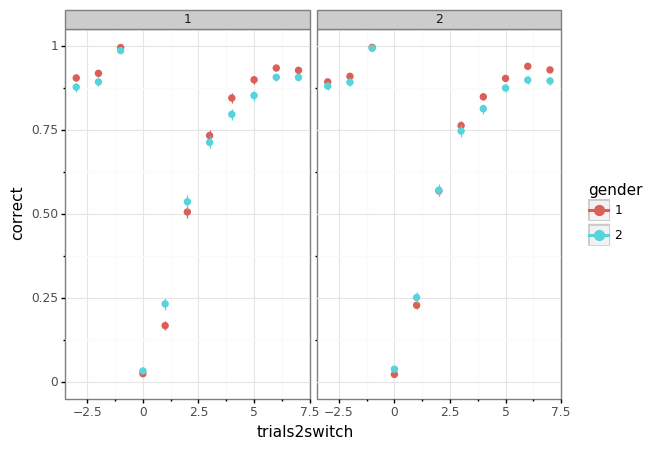

In [80]:
g = (gg.ggplot(true_dat, gg.aes('trials2switch', 'correct', color='gender'))
 + gg.stat_summary()
 + gg.stat_summary(gg.geom='line')
 + gg.coord_cartesian(xlim=(-3, 7))
 + gg.facet_wrap('~ agegroup')
)
g.draw()
g.save(os.path.join(plot_dir, 'mouse_trial_correct.png'))

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


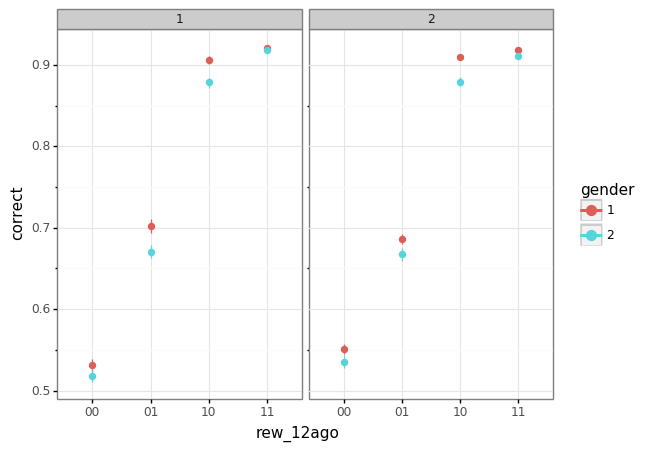

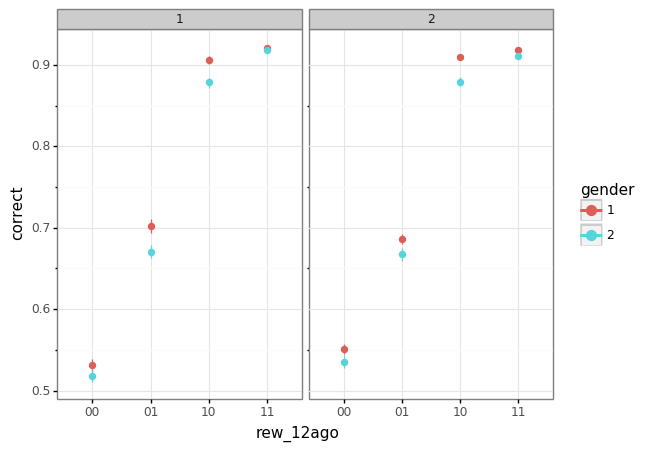

In [85]:
sub_dat = true_dat.loc[(true_dat.rew_12ago != '0n') * (true_dat.rew_12ago != '1n') * (true_dat.rew_12ago != 'nn')]
g = (gg.ggplot(sub_dat, gg.aes('rew_12ago', 'correct', color='gender'))
     + gg.stat_summary()
     + gg.facet_wrap('~ agegroup')
)
g.draw()

In [ ]:
g = (gg.ggplot(true_dat, gg.aes('block_trial', 'correct', color='gender'))
 + gg.stat_summary()
 + gg.facet_wrap('~ agegroup')
)
g.draw()
g.save(os.path.join(plot_dir, 'mouse_trial_correct.png'))

In [ ]:
g = (gg.ggplot(true_dat, gg.aes('block', 'correct', color='gender', group='gender'))
 + gg.stat_summary()
 + gg.facet_wrap('~ agegroup')
)
g.draw()
g.save(os.path.join(plot_dir, 'mouse_block_correct.png'))

In [ ]:
g = (gg.ggplot(true_dat, gg.aes('session', 'correct', color='gender'))
 + gg.stat_summary()
 + gg.facet_wrap('~ agegroup')
)
g.draw()
g.save(os.path.join(plot_dir, 'mouse_session_correct.png'))